In [101]:
import pandas as pd

# Assuming this function needs to be defined:
def fahrenheit_to_celsius(temp_f):
    return (temp_f - 32) * 5/9

class SoyGDD:
    def __init__(self, daily_temp_df, time_column, min_temp_column, max_temp_column, celsius=True):
        self.daily_temp_df = daily_temp_df
        self.time_column = time_column
        self.min_temp_column = min_temp_column
        self.max_temp_column = max_temp_column
        self.celsius = celsius

        # Ensure the time column is of datetime type
        self.daily_temp_df[self.time_column] = pd.to_datetime(self.daily_temp_df[self.time_column])

        # Convert the temperature to Celsius if required
        if not self.celsius:
            self.daily_temp_df[self.min_temp_column] = self.daily_temp_df[self.min_temp_column].apply(fahrenheit_to_celsius)
            self.daily_temp_df[self.max_temp_column] = self.daily_temp_df[self.max_temp_column].apply(fahrenheit_to_celsius)
    
    def soy_gdd(self, start_date, end_date):
        start_date = pd.Timestamp(start_date)
        end_date = pd.Timestamp(end_date)

        date_mask = (self.daily_temp_df[self.time_column] >= start_date) & (self.daily_temp_df[self.time_column] <= end_date)
        masked_data = self.daily_temp_df.loc[date_mask].copy()

        gdd_values = []
        cumulative_gdd = 0

        for index, row in masked_data.iterrows():
            min_temp = max(row[self.min_temp_column], 10 if self.celsius else 50)
            max_temp = min(row[self.max_temp_column], 30 if self.celsius else 86)

            mean_temp = (min_temp + max_temp) / 2
            base_temp = 10 if self.celsius else 50
            gdd = max(mean_temp - base_temp, 0)

            gdd_values.append(gdd)
            cumulative_gdd += gdd

        masked_data['GDD'] = gdd_values
        masked_data['Cumulative_GDD'] = masked_data['GDD'].cumsum()

        return masked_data


In [102]:
data = pd.read_csv("combined_data NOAA Becker.csv")

In [103]:
#Input data using SoyGDD instance for all 16 weather stations
soy_Becker1951 = SoyGDD(data, time_column = 'time', min_temp_column = 'tmin',max_temp_column = 'tmax')

In [104]:
import pandas as pd

# Assuming 'data' DataFrame is already loaded with the necessary columns
# and the SoyGDD class is already defined as before

# Function to convert Celsius to Fahrenheit
def celsius_to_fahrenheit(celsius):
    return (celsius * 9/5) + 32

# Iterate over each year from 1951 to 2023
for year in range(1951, 2024):
    # Instantiate the SoyGDD class for the year
    soy_gdd_instance = SoyGDD(data, 'time', 'tmin', 'tmax')

    # Define the start and end dates for the year
    start_date = pd.to_datetime(f"{year}-01-01").date()
    end_date = pd.to_datetime(f"{year}-12-31").date()

    # Calculate the GDD for the year
    gdd_results = soy_gdd_instance.soy_gdd(start_date, end_date)

    # Convert GDD and Cumulative_GDD from Celsius to Fahrenheit
    gdd_results['GDD'] = gdd_results['GDD'].apply(celsius_to_fahrenheit)
    gdd_results['Cumulative_GDD'] = gdd_results['Cumulative_GDD'].apply(celsius_to_fahrenheit)

    # Print only the relevant columns (Time, GDD, and Cumulative_GDD)
    print(f"GDD Results for {year} (in Fahrenheit):\n", gdd_results[['time', 'GDD', 'Cumulative_GDD']], "\n")

GDD Results for 1951 (in Fahrenheit):
           time   GDD  Cumulative_GDD
0   1951-01-01  32.0       32.000000
1   1951-01-02  32.0       32.000000
2   1951-01-03  32.0       32.000000
3   1951-01-04  32.0       32.000000
4   1951-01-05  32.0       32.000000
..         ...   ...             ...
360 1951-12-27  32.0     2305.920312
361 1951-12-28  32.0     2305.920312
362 1951-12-29  32.0     2305.920312
363 1951-12-30  32.0     2305.920312
364 1951-12-31  32.0     2305.920312

[365 rows x 3 columns] 

GDD Results for 1952 (in Fahrenheit):
           time   GDD  Cumulative_GDD
365 1952-01-01  32.0       32.000000
366 1952-01-02  32.0       32.000000
367 1952-01-03  32.0       32.000000
368 1952-01-04  32.0       32.000000
369 1952-01-05  32.0       32.000000
..         ...   ...             ...
726 1952-12-27  32.0     2767.936719
727 1952-12-28  32.0     2767.936719
728 1952-12-29  32.0     2767.936719
729 1952-12-30  32.0     2767.936719
730 1952-12-31  32.0     2767.936719

[366 ro

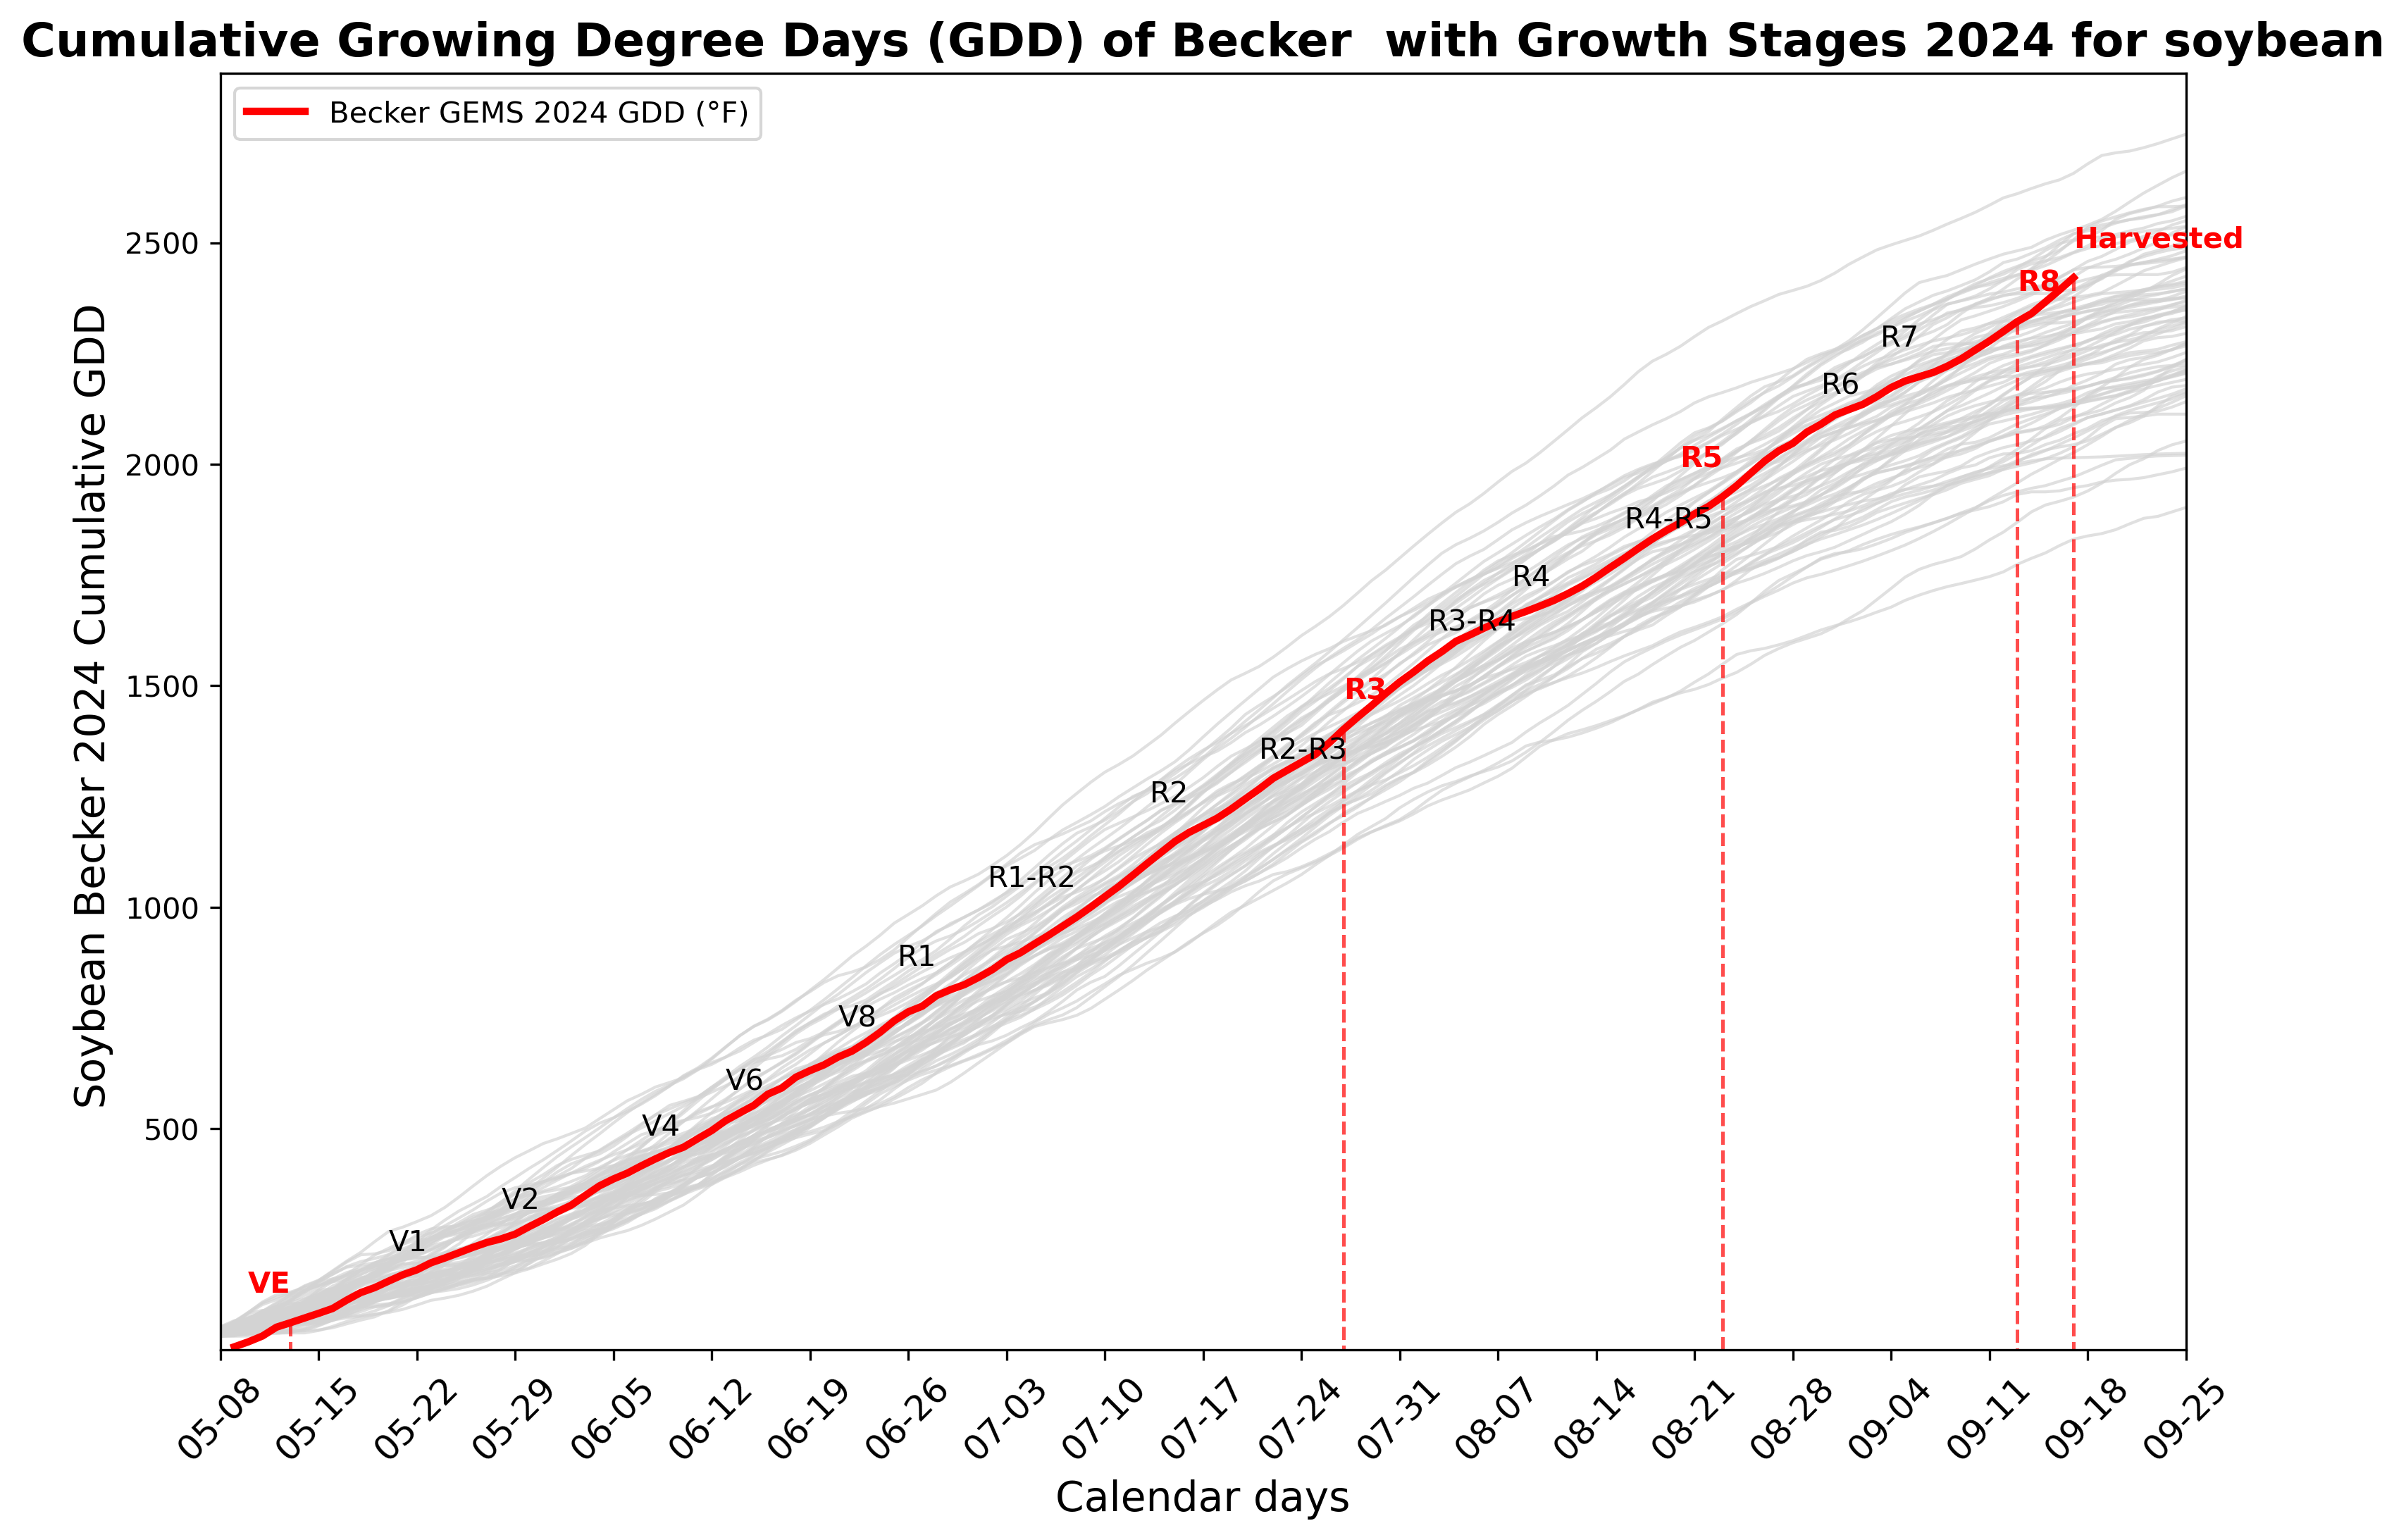

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load the Becker 2023 CSV file
file_path = "Soy_gdd_BeckerGEMS2024.csv"
file_path1 = 'Becker 2024 Soy growth stages.csv'
becker_data = pd.read_csv(file_path, parse_dates=['datetime'])

# Load Growth Staging Data
growth_staging = pd.read_csv(file_path1)
growth_staging.rename(columns=lambda x: x.strip(), inplace=True)
growth_staging['Date'] = pd.to_datetime(growth_staging['Date'] + '-2024', format='%d-%b-%Y', errors='coerce')

# Get the most frequent (mode) growth stage for each date
growth_staging_mode = growth_staging.groupby('Date')['Growth Stage'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index()

# Merge Growth Staging Data with Becker GDD Data
becker_data = pd.merge(becker_data, growth_staging_mode, left_on='datetime', right_on='Date', how='left')

# Function to convert Celsius to Fahrenheit
def celsius_to_fahrenheit(celsius):
    return (celsius * 9/5) + 32

# Initialize Figure
fig, ax1 = plt.subplots(figsize=(12, 8), dpi=300)

# Manually define Month-Day labels for x-axis (from May 5 to November 10)
manual_dates = pd.date_range("2024-05-08", "2024-09-25").strftime('%m-%d').tolist()

# Loop through years and plot each year's GDD in **light gray (1951–2022)** and **highlight 2023 in red**
for year in range(1951, 2024):  # Ensure 2023 is included
    if year in [2000, 2016]:  # Skip these years
        continue

    try:
        # Simulating data retrieval from a function (replace with actual data)
        soy_gdd_instance = SoyGDD(data, 'time', 'tmin', 'tmax')  # Assuming you have this function
        gdd_results = soy_gdd_instance.soy_gdd(pd.to_datetime(f"{year}-05-08").date(),
                                                pd.to_datetime(f"{year}-09-25").date())

        # Convert **only historical GDD** to Fahrenheit
        gdd_results['Cumulative_GDD'] = gdd_results['Cumulative_GDD'].apply(celsius_to_fahrenheit)
        gdd_results['Month_Day'] = gdd_results['time'].dt.strftime('%m-%d')

        # **Plot all historical years (1951–2022) in light gray**
        if year != 2024:
            ax1.plot(gdd_results['Month_Day'], gdd_results['Cumulative_GDD'], 
                     color='lightgray', alpha=0.7, linewidth=1)
        else:
            # **Highlight 2024 in red**
            ax1.plot(gdd_results['Month_Day'], gdd_results['Cumulative_GDD'], 
                     color='lightgray', linewidth=2.5, linestyle='solid')

    except:
        continue

# **Overlay Becker 2023 GDD (Keep in Celsius) on the same y-axis**
becker_data['Month_Day'] = becker_data['datetime'].dt.strftime('%m-%d')

# Filter only data within May 5 to November 10
becker_filtered = becker_data[becker_data['Month_Day'].isin(manual_dates)]

# Plot Becker 2023 GDD in **bold blue** (Celsius, dashed)
ax1.plot(becker_filtered['Month_Day'], becker_filtered['Cumulative_GDD'], 
         color='red', linewidth=2.5, linestyle='solid', label='Becker GEMS 2024 GDD (°F)')

# Add Growth Stage Annotations with better positioning
for i, row in becker_filtered.dropna(subset=['Growth Stage']).iterrows():
    label_offset = 55  # Slightly higher vertical offset
    text_align = 'center'  # Default alignment

    # Highlight important growth stages with bold red text
    if row['Growth Stage'] in ['VE', 'V7', 'V10', 'R3','R5', 'R8', 'Harvested']:
        label_offset = 55  # Increase spacing for key stages

        # Vertical dashed line from scatter point to x-axis
        ax1.plot([row['Month_Day'], row['Month_Day']], [row['Cumulative_GDD'], 0], 
                 color='red', linestyle='--', linewidth=1.2, alpha=0.7)  # Dashed lines with transparency
    
    # **Dynamically shift labels to prevent overlap**
    if i % 2 == 0:
        text_align = 'right'  # Shift alternate labels to the right
    else:
        text_align = 'left'  # Shift alternate labels to the left

    # **Place the label dynamically above the GDD curve with a white background**
    ax1.text(row['Month_Day'], row['Cumulative_GDD'] + label_offset, row['Growth Stage'], 
             fontsize=10, ha=text_align, va='bottom', 
             color='red' if row['Growth Stage'] in ['VE', 'V7', 'V10', 'R3','R5', 'R8', 'Harvested'] else 'black', 
             fontweight='bold' if row['Growth Stage'] in ['VE', 'V7', 'V10', 'R3','R5', 'R8', 'Harvested'] else 'normal',
             bbox=dict(facecolor='none', edgecolor='none', boxstyle='round,pad=0.3'))  # White background for readability


# Customize Primary Y-Axis (Historical GDD in °F, Becker in °C)
ax1.set_xlabel('Calendar days', fontsize=14)
ax1.set_ylabel(' Soybean Becker 2024 Cumulative GDD', fontsize=14, color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Customize x-axis with manual labels
ax1.set_xticks(range(0, len(manual_dates), 7))  # Every 7th day
ax1.set_xticklabels(manual_dates[::7], rotation=45, fontsize=12)

# Set limits
ax1.set_xlim(0, len(manual_dates) - 1)
ax1.set_ylim(bottom=1)

# Add legends
ax1.legend(loc="upper left")

# Title
plt.title('Cumulative Growing Degree Days (GDD) of Becker  with Growth Stages 2024 for soybean', fontsize=16, weight='bold')

# Show the plot
plt.show()


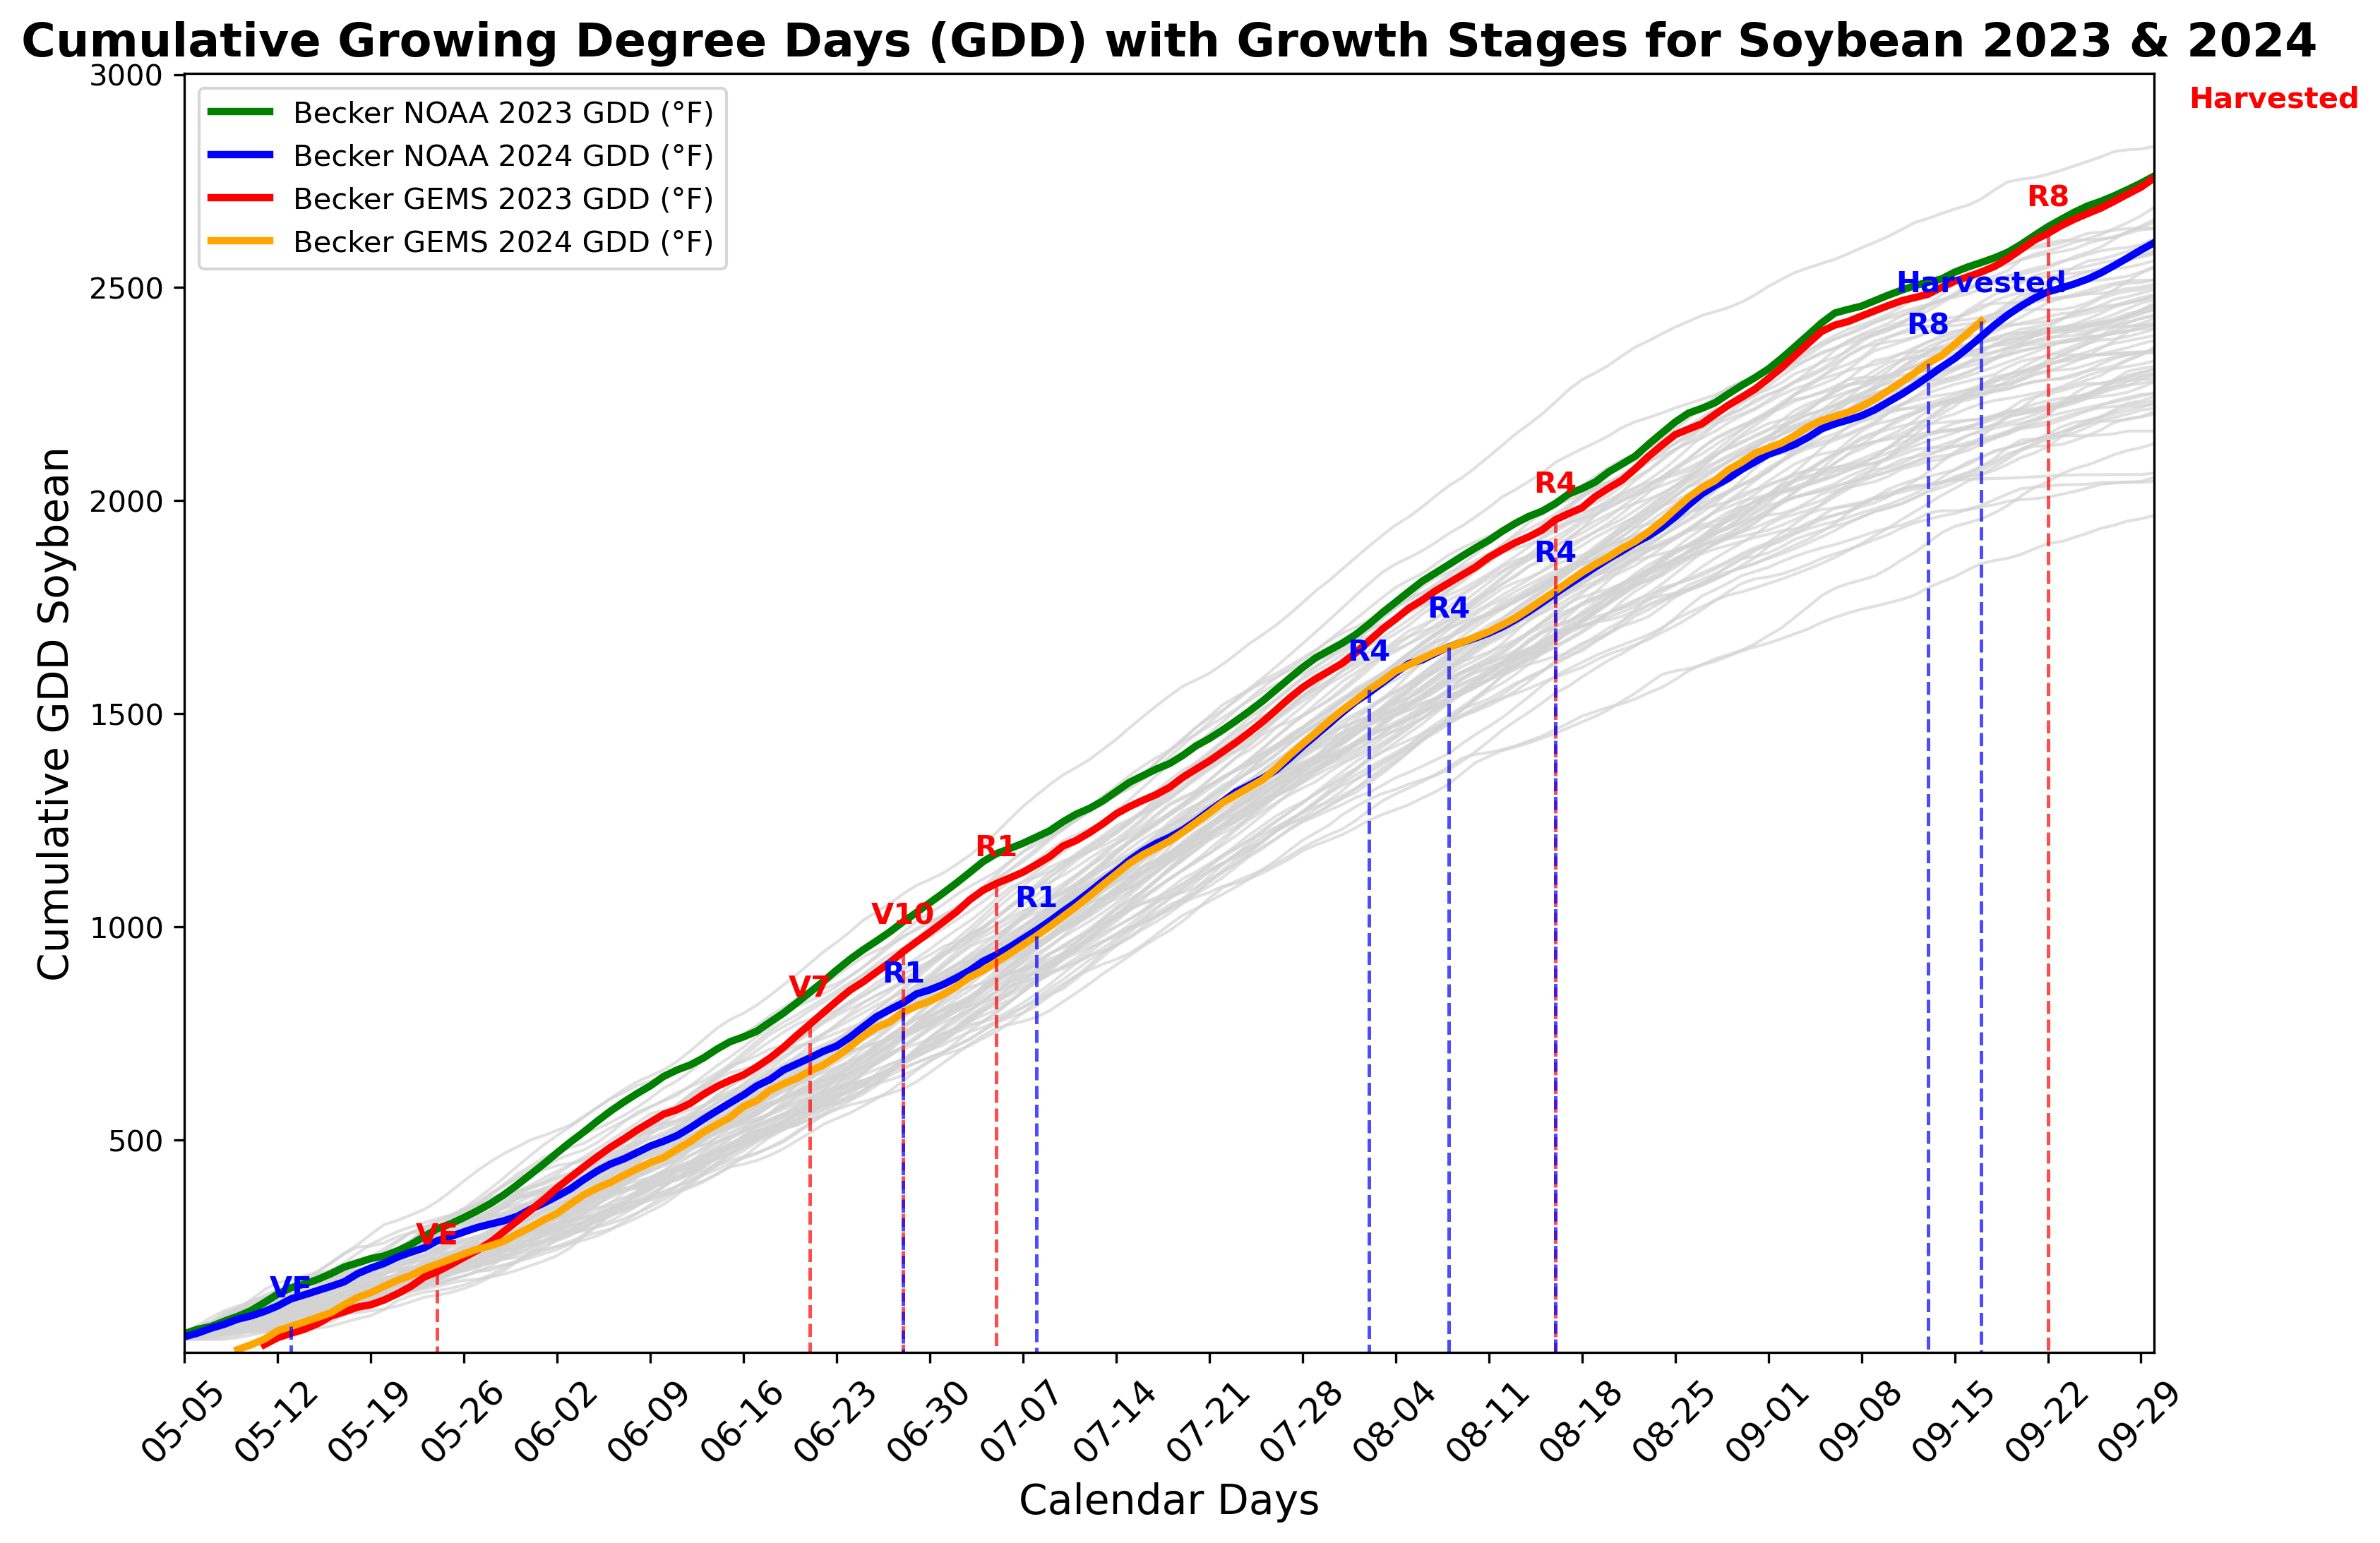

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load Becker 2023 & 2024 GDD Data
file_path_2023 = "Soy_gdd_BeckerGEMS2023.csv"
file_path_2024 = "Soy_gdd_BeckerGEMS2024.csv"
growth_staging_2023_file = "Becker 2023 Soy growth stages.csv"
growth_staging_2024_file = "Becker 2024 Soy growth stages.csv"

becker_data_2023 = pd.read_csv(file_path_2023, parse_dates=['datetime'])
becker_data_2024 = pd.read_csv(file_path_2024, parse_dates=['datetime'])

# Load Growth Staging Data for 2023 & 2024
growth_staging_2023 = pd.read_csv(growth_staging_2023_file)
growth_staging_2024 = pd.read_csv(growth_staging_2024_file)

# Clean Column Names
growth_staging_2023.rename(columns=lambda x: x.strip(), inplace=True)
growth_staging_2024.rename(columns=lambda x: x.strip(), inplace=True)

# Convert Date Column to Proper Format
growth_staging_2023['Date'] = pd.to_datetime(growth_staging_2023['Date'] + '-2023', format='%d-%b-%Y', errors='coerce')
growth_staging_2024['Date'] = pd.to_datetime(growth_staging_2024['Date'] + '-2024', format='%d-%b-%Y', errors='coerce')

# Function to Get Mode of Growth Stage Without Errors
def get_mode(series):
    mode_values = series.mode()
    return mode_values[0] if not mode_values.empty else None

# Get Mode Growth Stage for Each Date (Handling Empty Cases)
growth_staging_mode_2023 = growth_staging_2023.groupby('Date')['Growth Stage'].agg(get_mode).reset_index()
growth_staging_mode_2024 = growth_staging_2024.groupby('Date')['Growth Stage'].agg(get_mode).reset_index()

# Merge Growth Staging Data with Becker GDD Data
becker_data_2023 = pd.merge(becker_data_2023, growth_staging_mode_2023, left_on='datetime', right_on='Date', how='left')
becker_data_2024 = pd.merge(becker_data_2024, growth_staging_mode_2024, left_on='datetime', right_on='Date', how='left')

# Function to Convert Celsius to Fahrenheit
def celsius_to_fahrenheit(celsius):
    return (celsius * 9/5) + 32

# Initialize Figure
fig, ax1 = plt.subplots(figsize=(12, 8), dpi=300)

# Define X-Axis Labels (Manual Month-Day Labels)
manual_dates = pd.date_range("2023-05-05", "2023-09-30").strftime('%m-%d').tolist()

# Plot Historical NOAA GDD (1951-2022) and NOAA 2023 & 2024
for year in range(1951, 2025):
    if year in [2000, 2016]:  # Skip specific years
        continue

    try:
        # Simulating data retrieval from a function (replace with actual data)
        soy_gdd_instance = SoyGDD(data, 'time', 'tmin', 'tmax')  # Assuming you have this function
        gdd_results = soy_gdd_instance.soy_gdd(pd.to_datetime(f"{year}-05-05").date(),
                                               pd.to_datetime(f"{year}-09-30").date())

        # Convert only historical GDD to Fahrenheit
        gdd_results['Cumulative_GDD'] = gdd_results['Cumulative_GDD'].apply(celsius_to_fahrenheit)
        gdd_results['Month_Day'] = gdd_results['time'].dt.strftime('%m-%d')

        # Highlight 2024 in Blue
        if year == 2024:
            ax1.plot(gdd_results['Month_Day'], gdd_results['Cumulative_GDD'], 
                     color='blue', linewidth=2.5, linestyle='solid', label="Becker NOAA 2024 GDD (°F)")

        # Highlight 2023 in Green
        elif year == 2023:
            ax1.plot(gdd_results['Month_Day'], gdd_results['Cumulative_GDD'], 
                     color='green', linewidth=2.5, linestyle='solid', label="Becker NOAA 2023 GDD (°F)")

        # Other years in Light Gray
        else:
            ax1.plot(gdd_results['Month_Day'], gdd_results['Cumulative_GDD'], 
                     color='lightgray', alpha=0.7, linewidth=1)

    except:
        continue

# Overlay Becker 2023 & 2024 Data
becker_data_2023['Month_Day'] = becker_data_2023['datetime'].dt.strftime('%m-%d')
becker_data_2024['Month_Day'] = becker_data_2024['datetime'].dt.strftime('%m-%d')

# Plot Becker GEMS 2023 GDD (Red Solid Line)
ax1.plot(becker_data_2023['Month_Day'], becker_data_2023['Cumulative_GDD'], 
         color='red', linewidth=2.5, linestyle='solid', label='Becker GEMS 2023 GDD (°F)')

# Plot Becker GEMS 2024 GDD (Orange Solid Line)
ax1.plot(becker_data_2024['Month_Day'], becker_data_2024['Cumulative_GDD'], 
         color='orange', linewidth=2.5, linestyle='solid', label='Becker GEMS 2024 GDD (°F)')

# Annotate Key Growth Stages for 2023
for i, row in becker_data_2023.dropna(subset=['Growth Stage']).iterrows():
    if row['Growth Stage'] in ['VE', 'V7', 'V10', 'R1', 'R4', 'R8', 'Harvested']:
        ax1.plot([row['Month_Day'], row['Month_Day']], [row['Cumulative_GDD'], 0], 
                 color='red', linestyle='--', linewidth=1.2, alpha=0.7)
        
        ax1.text(row['Month_Day'], row['Cumulative_GDD'] + 50, row['Growth Stage'], 
                 fontsize=10, ha='center', va='bottom', color='red', fontweight='bold')

# Add Growth Stage Annotations for 2024
for i, row in becker_filtered_2024.dropna(subset=['Growth Stage']).iterrows():
    if row['Growth Stage'] in ['VE', 'V7', 'V10', 'R1','R4', 'R8', 'Harvested']:
        ax1.plot([row['Month_Day'], row['Month_Day']], [row['Cumulative_GDD'], 0], 
                 color='blue', linestyle='--', linewidth=1.2, alpha=0.7)  
        ax1.text(row['Month_Day'], row['Cumulative_GDD'] + 55, row['Growth Stage'], 
                 fontsize=10, ha='center', va='bottom', color='blue', fontweight='bold')

# Customize X-Axis Labels
ax1.set_xticks(range(0, len(manual_dates), 7))
ax1.set_xticklabels(manual_dates[::7], rotation=45, fontsize=12)

# Customize Y-Axis and Labels
ax1.set_xlabel('Calendar Days', fontsize=14)
ax1.set_ylabel('Cumulative GDD Soybean', fontsize=14, color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Set Limits
ax1.set_xlim(0, len(manual_dates) - 1)
ax1.set_ylim(bottom=1)

# Add Legends
ax1.legend(loc="upper left")

# Add Title
plt.title('Cumulative Growing Degree Days (GDD) with Growth Stages for Soybean 2023 & 2024', fontsize=16, weight='bold')

# Show the Plot
plt.show()


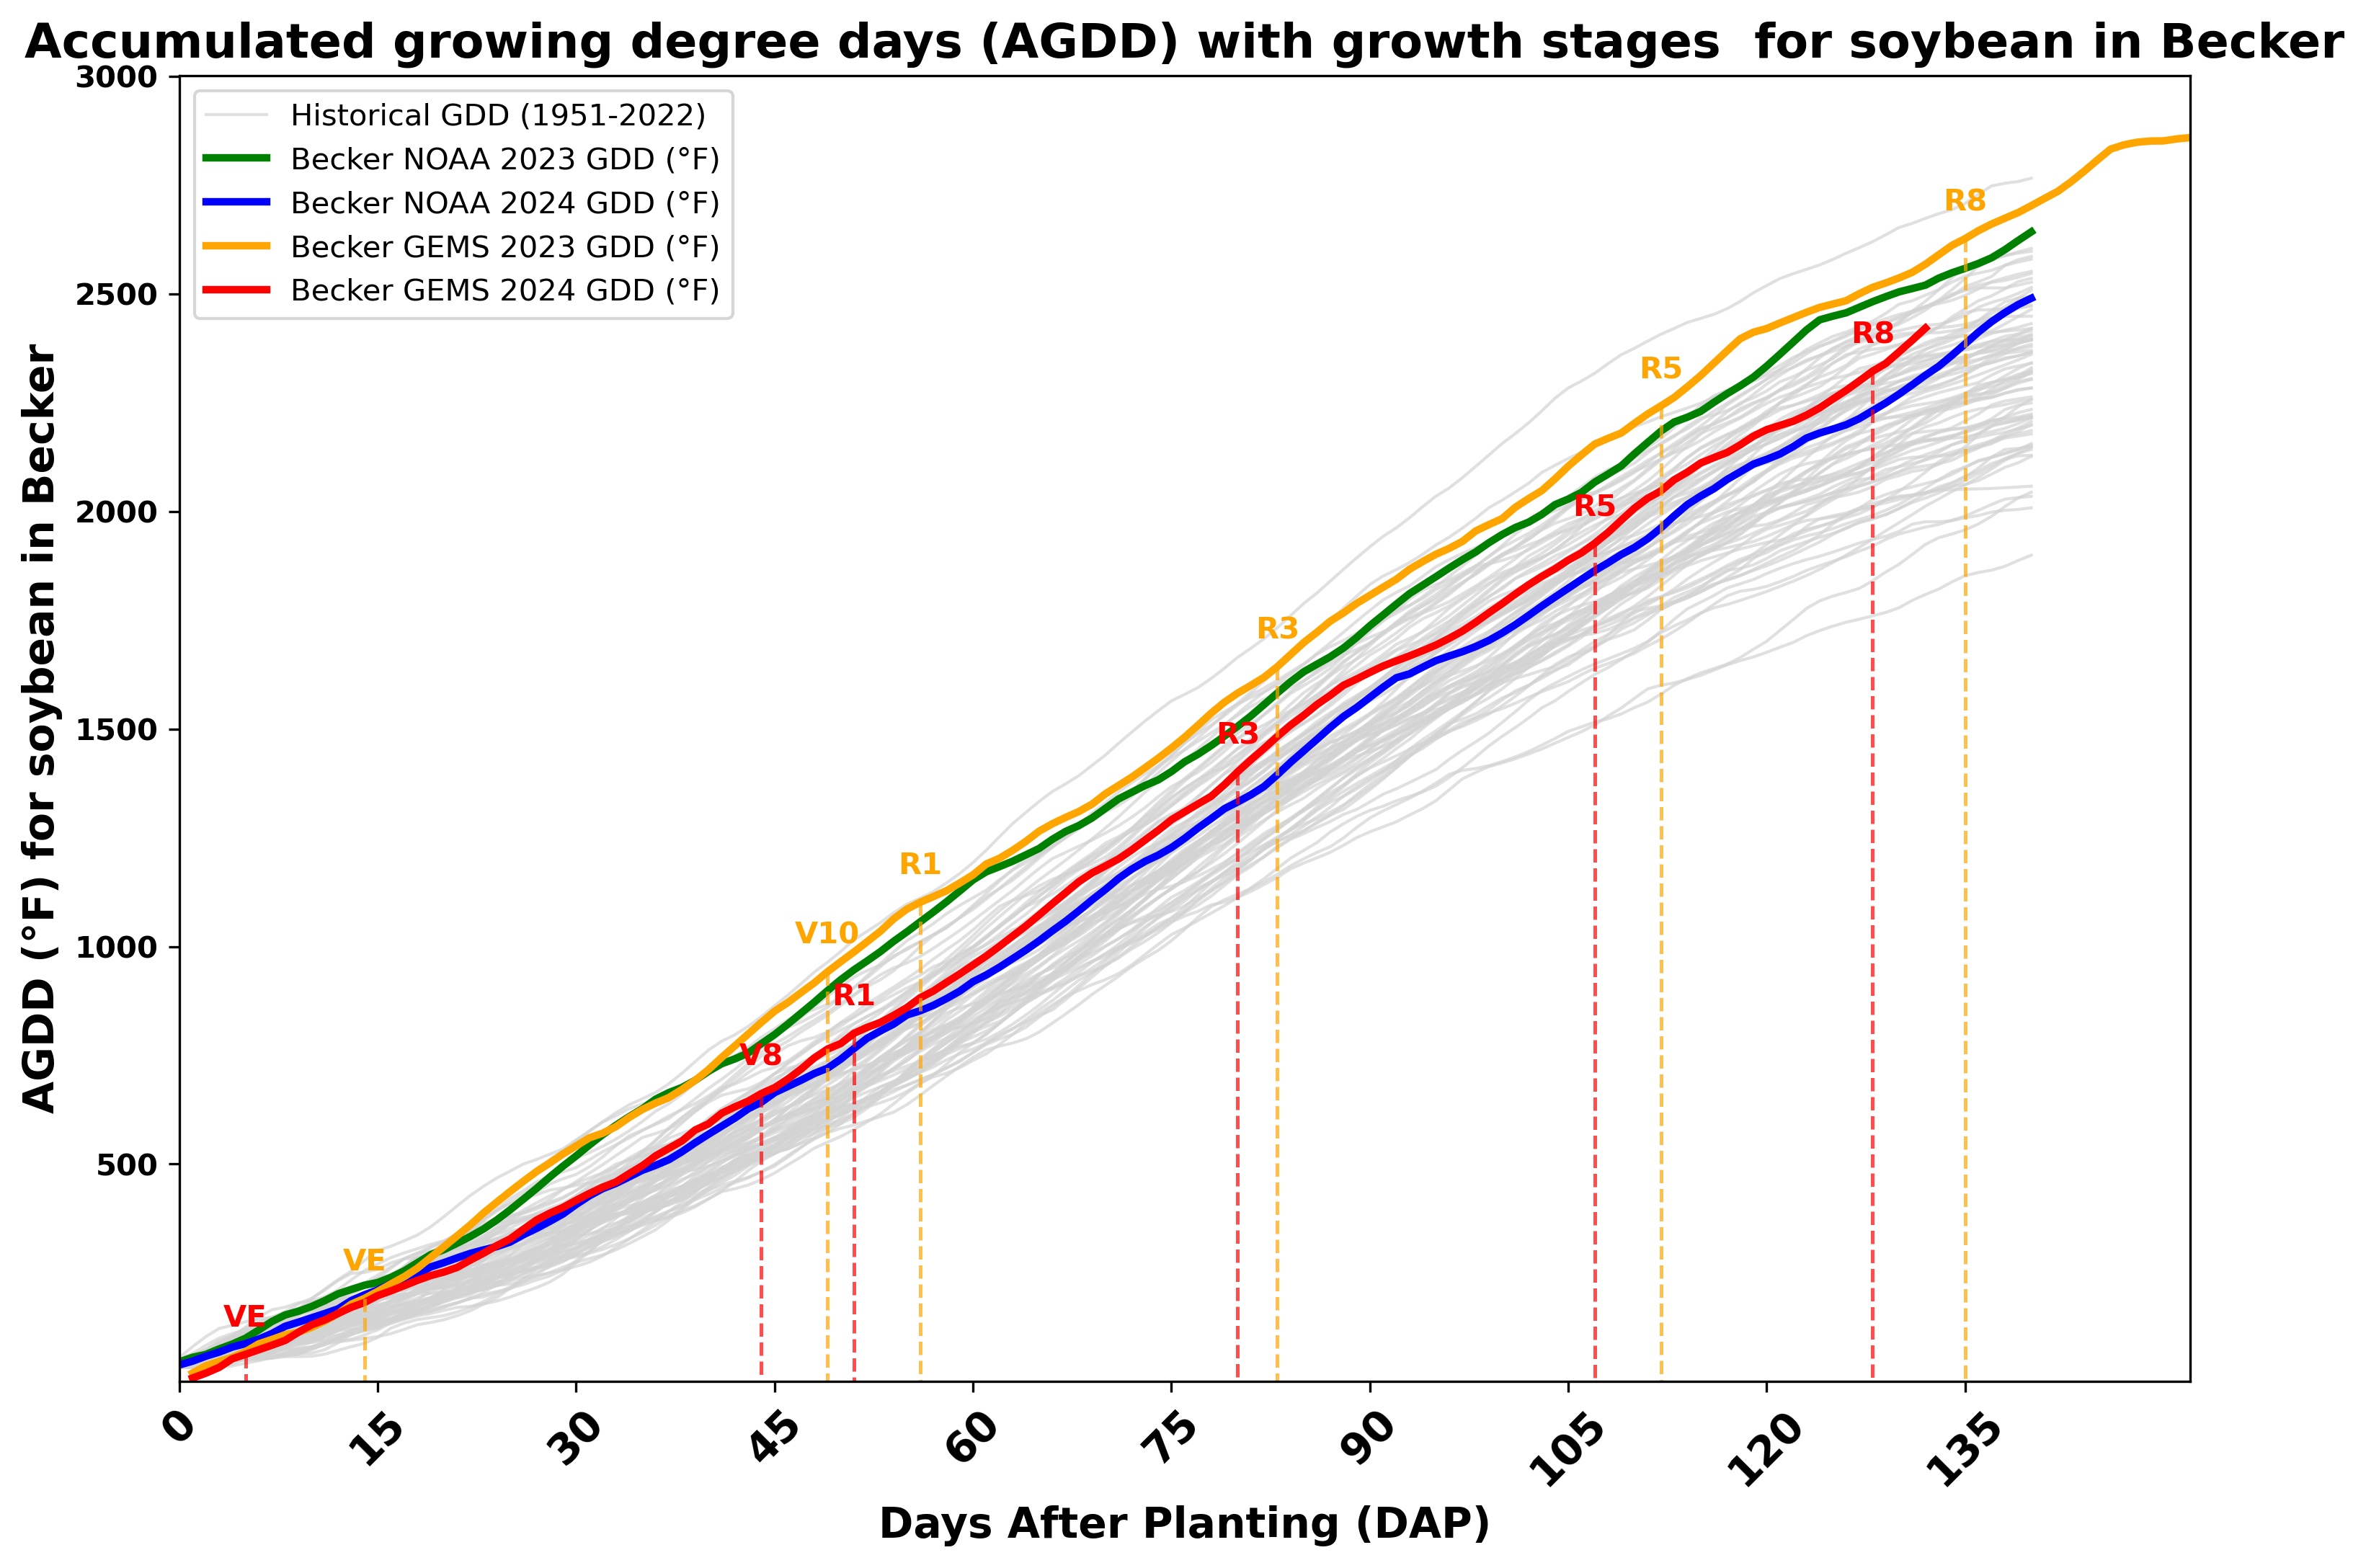

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load Becker 2023 & 2024 GDD Data
file_path_2023 = "Soy_gdd_BeckerGEMS2023.csv"
file_path_2024 = "Soy_gdd_BeckerGEMS2024.csv"
growth_staging_2023_file = "Becker 2023 Soy growth stages.csv"
growth_staging_2024_file = "Becker 2024 Soy growth stages.csv"

becker_data_2023 = pd.read_csv(file_path_2023, parse_dates=['datetime'])
becker_data_2024 = pd.read_csv(file_path_2024, parse_dates=['datetime'])

# Define planting dates for DAP calculation
planting_date_2023 = pd.Timestamp("2023-05-10")
planting_date_2024 = pd.Timestamp("2024-05-08")

# Compute Days After Planting (DAP)
becker_data_2023['DAP'] = (becker_data_2023['datetime'] - planting_date_2023).dt.days
becker_data_2024['DAP'] = (becker_data_2024['datetime'] - planting_date_2024).dt.days

# Load Growth Staging Data for 2023 & 2024
growth_staging_2023 = pd.read_csv(growth_staging_2023_file)
growth_staging_2024 = pd.read_csv(growth_staging_2024_file)

# Clean Column Names
growth_staging_2023.rename(columns=lambda x: x.strip(), inplace=True)
growth_staging_2024.rename(columns=lambda x: x.strip(), inplace=True)

# Convert Date Column to Proper Format
growth_staging_2023['Date'] = pd.to_datetime(growth_staging_2023['Date'] + '-2023', format='%d-%b-%Y', errors='coerce')
growth_staging_2024['Date'] = pd.to_datetime(growth_staging_2024['Date'] + '-2024', format='%d-%b-%Y', errors='coerce')

# Function to Get Mode of Growth Stage Without Errors
def get_mode(series):
    mode_values = series.mode()
    return mode_values[0] if not mode_values.empty else None

# Get Mode Growth Stage for Each Date (Handling Empty Cases)
growth_staging_mode_2023 = growth_staging_2023.groupby('Date')['Growth Stage'].agg(get_mode).reset_index()
growth_staging_mode_2024 = growth_staging_2024.groupby('Date')['Growth Stage'].agg(get_mode).reset_index()

# Merge Growth Staging Data with Becker GDD Data
becker_data_2023 = pd.merge(becker_data_2023, growth_staging_mode_2023, left_on='datetime', right_on='Date', how='left')
becker_data_2024 = pd.merge(becker_data_2024, growth_staging_mode_2024, left_on='datetime', right_on='Date', how='left')

# Function to Convert Celsius to Fahrenheit
def celsius_to_fahrenheit(celsius):
    return (celsius * 9/5) + 32

# Initialize Figure
fig, ax1 = plt.subplots(figsize=(12, 8), dpi=300)

# Plot All Historical NOAA GDD Lines (1951-2022) in Light Gray
gray_label_added = False  # Ensure only one label is included

for year in range(1951, 2025):  # Includes 2023 & 2024 to be plotted separately
    try:
        # Simulating data retrieval from a function (replace with actual data)
        soy_gdd_instance = SoyGDD(data, 'time', 'tmin', 'tmax')  # Assuming you have this function
        gdd_results = soy_gdd_instance.soy_gdd(pd.to_datetime(f"{year}-05-05").date(),
                                               pd.to_datetime(f"{year}-09-22").date())

        # Convert GDD to Fahrenheit
        gdd_results['Cumulative_GDD'] = gdd_results['Cumulative_GDD'].apply(celsius_to_fahrenheit)
        gdd_results['DAP'] = (gdd_results['time'] - pd.to_datetime(f"{year}-05-05")).dt.days

        # Plot Historical Data (1951-2022) in Light Gray
        if year < 2023:
            if not gray_label_added:
                ax1.plot(gdd_results['DAP'], gdd_results['Cumulative_GDD'], 
                         color='lightgray', alpha=0.7, linewidth=1, label="Historical GDD (1951-2022)")
                gray_label_added = True
            else:
                ax1.plot(gdd_results['DAP'], gdd_results['Cumulative_GDD'], 
                         color='lightgray', alpha=0.7, linewidth=1)

        # Highlight NOAA 2023 in Green
        elif year == 2023:
            ax1.plot(gdd_results['DAP'], gdd_results['Cumulative_GDD'], 
                     color='green', linewidth=2.5, linestyle='solid', label="Becker NOAA 2023 GDD (°F)")

        # Highlight NOAA 2024 in Blue
        elif year == 2024:
            ax1.plot(gdd_results['DAP'], gdd_results['Cumulative_GDD'], 
                     color='blue', linewidth=2.5, linestyle='solid', label="Becker NOAA 2024 GDD (°F)")

    except Exception as e:
        print(f"Error processing year {year}: {e}")
        continue

# Plot Becker GEMS 2023 GDD (Red Solid Line)
ax1.plot(becker_data_2023['DAP'], becker_data_2023['Cumulative_GDD'], 
         color='orange', linewidth=2.5, linestyle='solid', label='Becker GEMS 2023 GDD (°F)')

# Plot Becker GEMS 2024 GDD (Orange Solid Line)
ax1.plot(becker_data_2024['DAP'], becker_data_2024['Cumulative_GDD'], 
         color='red', linewidth=2.5, linestyle='solid', label='Becker GEMS 2024 GDD (°F)')

# Annotate Key Growth Stages for 2023
for i, row in becker_data_2023.dropna(subset=['Growth Stage']).iterrows():
    if row['Growth Stage'] in ['VE', 'V10','R1','R3', 'R5', 'R8']:
        ax1.plot([row['DAP'], row['DAP']], [row['Cumulative_GDD'], 0], 
                 color='orange', linestyle='--', linewidth=1.2, alpha=0.7)
        
        ax1.text(row['DAP'], row['Cumulative_GDD'] + 50, row['Growth Stage'], 
                 fontsize=10, ha='center', va='bottom', color='orange', fontweight='bold')

# Annotate Key Growth Stages for 2024
for i, row in becker_data_2024.dropna(subset=['Growth Stage']).iterrows():
    if row['Growth Stage'] in ['VE', 'V8', 'R1', 'R3', 'R5', 'R8']:
        ax1.plot([row['DAP'], row['DAP']], [row['Cumulative_GDD'], 0], 
                 color='red', linestyle='--', linewidth=1.2, alpha=0.7)  
        ax1.text(row['DAP'], row['Cumulative_GDD'] + 50, row['Growth Stage'], 
                 fontsize=10, ha='center', va='bottom', color='red', fontweight='bold')

# Customize X-Axis Labels to DAP
ax1.set_xticks(range(0, 140, 15))  # Every 15 DAP
ax1.set_xticklabels(range(0, 140, 15), rotation=45, fontsize=14, fontweight='bold')

# Customize Y-Axis and Labels
ax1.set_xlabel('Days After Planting (DAP)', fontsize=14, fontweight='bold')
ax1.set_ylabel('AGDD (°F) for soybean in Becker', fontsize=14, color='black', fontweight='bold')
ax1.tick_params(axis='y', labelcolor='black')
# Make Y-Axis Tick Labels Bold
for label in ax1.get_yticklabels():
    label.set_fontweight('bold')
# Set limits based on October 5
# Set Limits
ax1.set_xlim(left=0, right=max(becker_data_2024['DAP'].max(), becker_data_2023['DAP'].max(), 140))
ax1.set_ylim(bottom=1)

# Add Legends
ax1.legend(loc="upper left")

# Add Title
plt.title('Accumulated growing degree days (AGDD) with growth stages  for soybean in Becker', fontsize=16, weight='bold')
plt.savefig('BeckerSOy_gdd_plot.png', format='png', dpi=600, bbox_inches='tight')
# Show the Plot
plt.show()
